In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk
import os

In [2]:
# set random state for data split
random_state = 1234

# Datasets

### Functions for label cleaning and creating hugging face datasets

#### Function to get rid of duplicate texts with different labels and creating multi-label target (also making sure all labels are lists)
- NOTE: Need to make sure input df has only 2 columns that are named 'text', 'labels'
 
BEFORE:
| text | labels |
|----------|----------|
| "This is duplicate text" | "love" |
| "This is duplicate text" | "joy" |
| "example" | "fear"|

AFTER:
| text | labels |
|----------|----------|
| "This is duplicate text" | ["love", "joy"] |
| "example" | ["fear"]|


In [3]:
# combine duplicate texts with different labels so that it's just one unique text with multilabels
# combine duplicates and non-duplicates df
def to_multilabels_df(df):
    # find duplicates
    dups = df[df.duplicated(subset="text", keep=False)]
    # combine duplicate texts into 1 with multilabels target
    combined_labels_df = dups.groupby('text').agg(lambda x: list(set(x))).reset_index() # avoid duplicate label for the same text using set

    # get duplicate index as list
    dup_ids = dups.index.tolist()
    # get non-duplicates
    non_dups = df[~df.index.isin(dup_ids)]
    # change labels to list for non duplicates
    non_dups.loc[:, 'labels'] = non_dups['labels'].apply(lambda x: [x])

    # combine duplicates and non-duplicates in to 1 df
    combined_df = pd.concat([non_dups, combined_labels_df], ignore_index=True)

    return combined_df 

#### Function to change list of string labels to numerical (id) labels

Example sentiment labels/id:
| labels | id |
|----------|----------|
| "love" | 0 |
| "joy" | 1 |
| "sad" | 2 |
| "fear" | 3 |

BEFORE:
| text | labels |
|----------|----------|
| "This is duplicate text" | ["love", "joy"] |
| "example" | ["fear"]|

AFTER:
| text | labels |
|----------|----------|
| "This is duplicate text" | [0, 1] |
| "example" | [3]|

In [4]:
# convert list of labels to list of ids
def convert2id(label2id, label_list):
    return [label2id[label] for label in label_list]

#### Function to One-Hot-Encod (OHE) numerical/id labels (based on 28 GoEmotions labels)

For this example, assume there's 10 labels

Before:
| text | labels |
|----------|----------|
| "This is duplicate text" | [0, 1] |
| "example" | [3]|

After:
| text | labels |
|----------|----------|
| "This is duplicate text" | [<span style="color: green;">1</span>, <span style="color: green;">1</span>, 0, 0, 0, 0, 0, 0, 0, 0] |
| "example" | [0, 0, 0, <span style="color: green;">1</span>, 0, 0, 0, 0, 0, 0]|

In [5]:
def ohe(labels, num_labels):
    ohe_arr = np.zeros(num_labels, dtype=int)
    for label in labels:
        ohe_arr[label] = 1
    
    return ohe_arr

#### Function to convert pandas df to hugging face df and splitting dataset into train/val/test.
  - 4 cases are considered: 
    - only 1 (training) dataset present (no val/test) --> train split into train/val/test (80/20/20)
    - train/test present (no val) --> train split into train/val
    - train/valid present (no test) --> val will become test
    - all 3 (train/validation/test) present

In [6]:
# convert to huggingface dataset into 3 splits (train/val/test)
def split_convert2hf_dataset(train, val=None, test=None, random_state=1):
    # if train and val passed (no test), val becomes test
    if val is not None and test is None:
        test = val
        val = None

    train_hf_df = Dataset.from_pandas(train)

    # if there's test dataset
    if test is not None:
        test_hf_df = Dataset.from_pandas(test)

    # if there's no validation set
    if val is None:
        # 80% train, 20% test + val
        train_valtest = train_hf_df.train_test_split(test_size=0.2, seed=random_state)

        train_hf_df = train_valtest['train']
        val_hf_df = train_valtest["test"]

        # if no validation and test sets
        if test is None:
            # Split the 20% test + val in half val, half test
            val_test = train_valtest["test"].train_test_split(test_size=0.5, seed=random_state)

            val_hf_df = val_test["train"]
            test_hf_df = val_test["test"]
    else:
        # if val and test datasets provided
        val_hf_df = Dataset.from_pandas(val)
        test_hf_df = Dataset.from_pandas(test)


    return DatasetDict({
    'train': train_hf_df,
    'validation': val_hf_df,
    'test': test_hf_df
    })

#### Function to save processed Hugging Face dataset to disk

In [7]:
# function to save hf dataset on disk
def save_hf_dataset(file_path, dataset):
    # only save when file doesn't exist
    if not os.path.exists(file_path):
        dataset.save_to_disk(file_path)
    else:
        print("Dataset already exists.")

## Process datasets

### GoEmotions

In [8]:
goEmotions = load_dataset("google-research-datasets/go_emotions")
goEmotions

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [9]:
goEmotions["train"][:5]

{'text': ["My favourite food is anything I didn't have to cook myself.",
  'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
  'WHY THE FUCK IS BAYLESS ISOING',
  'To make her feel threatened',
  'Dirty Southern Wankers'],
 'labels': [[27], [27], [2], [14], [3]],
 'id': ['eebbqej', 'ed00q6i', 'eezlygj', 'ed7ypvh', 'ed0bdzj']}

In [10]:
# label2id, id2label
go_id2label = {}
go_label2id = {}
go_labels = goEmotions['train'].features['labels'].feature.names
num_go_labels = len(go_labels)

for idx, label in enumerate(go_labels):
    go_id2label[idx] = label
    go_label2id[label] = idx

go_id2label, go_label2id

({0: 'admiration',
  1: 'amusement',
  2: 'anger',
  3: 'annoyance',
  4: 'approval',
  5: 'caring',
  6: 'confusion',
  7: 'curiosity',
  8: 'desire',
  9: 'disappointment',
  10: 'disapproval',
  11: 'disgust',
  12: 'embarrassment',
  13: 'excitement',
  14: 'fear',
  15: 'gratitude',
  16: 'grief',
  17: 'joy',
  18: 'love',
  19: 'nervousness',
  20: 'optimism',
  21: 'pride',
  22: 'realization',
  23: 'relief',
  24: 'remorse',
  25: 'sadness',
  26: 'surprise',
  27: 'neutral'},
 {'admiration': 0,
  'amusement': 1,
  'anger': 2,
  'annoyance': 3,
  'approval': 4,
  'caring': 5,
  'confusion': 6,
  'curiosity': 7,
  'desire': 8,
  'disappointment': 9,
  'disapproval': 10,
  'disgust': 11,
  'embarrassment': 12,
  'excitement': 13,
  'fear': 14,
  'gratitude': 15,
  'grief': 16,
  'joy': 17,
  'love': 18,
  'nervousness': 19,
  'optimism': 20,
  'pride': 21,
  'realization': 22,
  'relief': 23,
  'remorse': 24,
  'sadness': 25,
  'surprise': 26,
  'neutral': 27})

In [11]:
# drop id column
goEmotions = goEmotions.remove_columns(['id'])
goEmotions

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5427
    })
})

In [12]:
num_go_labels

28

In [13]:
goEmotions["train"]['labels'][:10]

[[27], [27], [2], [14], [3], [26], [15], [8, 20], [0], [27]]

In [14]:
goEmotionsOhe = goEmotions.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
goEmotionsOhe

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5427
    })
})

In [54]:
display(goEmotions["train"]['labels'][7])
str(goEmotionsOhe['train']['labels'][7])

[8, 20]

'[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]'

In [ ]:
# save to disk
file_name = 'goEmotions_cleaned'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, goEmotionsOhe)

Dataset already exists.


### SemEvalWorkshop English

In [17]:
semEval = load_dataset("SemEvalWorkshop/sem_eval_2018_task_1", 'subtask5.english', trust_remote_code=True)
semEval

DatasetDict({
    train: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
        num_rows: 886
    })
})

In [18]:
semEval['train'][0]

{'ID': '2017-En-21441',
 'Tweet': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'anger': False,
 'anticipation': True,
 'disgust': False,
 'fear': False,
 'joy': False,
 'love': False,
 'optimism': True,
 'pessimism': False,
 'sadness': False,
 'surprise': False,
 'trust': True}

In [19]:
semEval_emotions = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

# emotions in goEmotions
in_goEmo = []
# emotions not in goEmotions
not_in_goEmo = []
for emo in semEval_emotions:
    if emo in go_labels:
        in_goEmo.append(emo)
    else:
        not_in_goEmo.append(emo)

print("Emotions in GoEmotions:", in_goEmo)
print("Emotions not in GoEmotions:", not_in_goEmo)

Emotions in GoEmotions: ['anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise']
Emotions not in GoEmotions: ['anticipation', 'pessimism', 'trust']


In [20]:
# get rid of columns not being used and rename 
remove_cols = not_in_goEmo + ["ID"]

semEval = semEval.remove_columns(remove_cols).rename_column("Tweet", "text")
semEval

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise'],
        num_rows: 886
    })
})

In [21]:
semEval['train'][2]

{'text': "@Max_Kellerman  it also helps that the majority of NFL coaching is inept. Some of Bill O'Brien's play calling was wow, ! #GOPATS",
 'anger': True,
 'disgust': True,
 'fear': False,
 'joy': True,
 'love': False,
 'optimism': True,
 'sadness': False,
 'surprise': False}

In [22]:
# get only True values from each emotion column
def get_emotions(row):
    emotions = [col for col in row.keys() if col != 'text' and row[col] == True]

    return emotions

In [23]:
# create new column 'labels'
semEval_new = semEval.map(lambda row: {'labels': get_emotions(row)})
semEval_new

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'labels'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'labels'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'labels'],
        num_rows: 886
    })
})

In [24]:
# remove original sentiment columns
semEval_new = semEval_new.remove_columns(in_goEmo)
semEval_new

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6838
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3259
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 886
    })
})

In [ ]:
# convert to pandas for more cleaning (do it for train/val/test)
# 1. some labels are empty arrays --> get rid of these examples
# 2. check for duplicates
semEval_train = semEval_new['train'].to_pandas()
semEval_val = semEval_new['validation'].to_pandas()
semEval_test = semEval_new['test'].to_pandas()

In [26]:
# get rid of empty labels
semEval_train = semEval_train[semEval_train['labels'].apply(lambda x: len(x) > 0)]
semEval_val = semEval_val[semEval_val['labels'].apply(lambda x: len(x) > 0)]
semEval_test = semEval_test[semEval_test['labels'].apply(lambda x: len(x) > 0)]

In [27]:
# check for duplicate text
display(semEval_train[semEval_train.duplicated(subset=['text'], keep=False)])
display(semEval_val[semEval_val.duplicated(subset=['text'], keep=False)])
semEval_test[semEval_test.duplicated(subset=['text'], keep=False)]

# no duplicates found

,text,labels


,text,labels


,text,labels


In [28]:
semEval_train

,text,labels
0,“Worry is a down payment on a problem you may ...,[optimism]
1,Whatever you decide to do make sure it makes y...,"[joy, love, optimism]"
2,@Max_Kellerman it also helps that the majorit...,"[anger, disgust, joy, optimism]"
3,Accept the challenges so that you can literall...,"[joy, optimism]"
4,My roommate: it's okay that we can't spell bec...,"[anger, disgust]"
...,...,...
6831,.@Travelanswerman: The possibilities R endless...,"[joy, optimism]"
6832,You have a #problem? Yes! Can you do #somethin...,"[anger, disgust]"
6834,@andreamitchell said @berniesanders not only d...,[surprise]
6835,@isthataspider @dhodgs i will fight this guy! ...,"[anger, disgust]"


In [29]:
# convert string labels to ids
semEval_train['labels'] = semEval_train['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
semEval_val['labels'] = semEval_val['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
semEval_test['labels'] = semEval_test['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))

In [30]:
# reseting index so that dataset doesn't get extra column named '__index_level_0__' when converting to hf df
semEval_train = semEval_train.reset_index(drop=True)
semEval_val = semEval_val.reset_index(drop=True)
semEval_test = semEval_test.reset_index(drop=True)

In [31]:
semEval_train

,text,labels
0,“Worry is a down payment on a problem you may ...,[20]
1,Whatever you decide to do make sure it makes y...,"[17, 18, 20]"
2,@Max_Kellerman it also helps that the majorit...,"[2, 11, 17, 20]"
3,Accept the challenges so that you can literall...,"[17, 20]"
4,My roommate: it's okay that we can't spell bec...,"[2, 11]"
...,...,...
6534,.@Travelanswerman: The possibilities R endless...,"[17, 20]"
6535,You have a #problem? Yes! Can you do #somethin...,"[2, 11]"
6536,@andreamitchell said @berniesanders not only d...,[26]
6537,@isthataspider @dhodgs i will fight this guy! ...,"[2, 11]"


In [32]:
# convert pandas df back to hf df
semEval_hf = split_convert2hf_dataset(semEval_train, semEval_val, semEval_test, random_state)
semEval_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6539
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 865
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3156
    })
})

In [33]:
# change labels to ohe
semEval_hf_ohe = semEval_hf.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
semEval_hf_ohe

Map:   0%|          | 0/6539 [00:00<?, ? examples/s]

Map:   0%|          | 0/865 [00:00<?, ? examples/s]

Map:   0%|          | 0/3156 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6539
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 865
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 3156
    })
})

In [34]:
display(semEval_hf["train"][2]['labels'])
str(semEval_hf_ohe["train"][2]['labels'])

[2, 11, 17, 20]

'[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]'

In [35]:
# save to disk
file_name = 'semEval_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, semEval_hf_ohe)

Dataset already exists.


### pashupatigupta twitter

In [73]:
pash = pd.read_csv('./datasets/pashupatigupta_emotions_twitter.csv')
pash

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [74]:
# rename column: content -> text
pash = pash.rename(columns={'sentiment': 'labels', 'content': 'text'})
pash = pash.drop('tweet_id', axis=1)
pash

,labels,text
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [75]:
pash['labels'].unique().tolist()

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

In [76]:
# get emotions only in goemotions labels (disregard others)
pash_redu = pash[pash["labels"].isin(go_labels)]
pash_redu

,labels,text
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
4,neutral,@dannycastillo We want to trade with someone w...
6,sadness,"I should be sleep, but im not! thinking about ..."
8,sadness,@charviray Charlene my love. I miss you
...,...,...
39993,neutral,"@sendsome2me haha, yeah. Twitter has many uses..."
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...


In [77]:
pash_redu_labels = pash_redu['labels'].unique().tolist()
pash_redu_labels

['sadness', 'neutral', 'surprise', 'love', 'relief', 'anger']

In [78]:
pash_cleaned = to_multilabels_df(pash_redu)
pash_cleaned

,labels,text
0,[sadness],Layin n bed with a headache ughhhh...waitin o...
1,[sadness],Funeral ceremony...gloomy friday...
2,[neutral],@dannycastillo We want to trade with someone w...
3,[sadness],"I should be sleep, but im not! thinking about ..."
4,[sadness],@charviray Charlene my love. I miss you
...,...,...
21368,"[sadness, surprise]",my tummy hurts
21369,[sadness],not feeling too great today
21370,[neutral],nothing
21371,"[sadness, surprise]",we're getting another puppy ... not cool... r...


In [79]:
# swap columns
pash_cleaned = pash_cleaned[['text', 'labels']]

In [80]:
# change labels to ids
pash_cleaned['labels'] = pash_cleaned['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
pash_cleaned

,text,labels
0,Layin n bed with a headache ughhhh...waitin o...,[25]
1,Funeral ceremony...gloomy friday...,[25]
2,@dannycastillo We want to trade with someone w...,[27]
3,"I should be sleep, but im not! thinking about ...",[25]
4,@charviray Charlene my love. I miss you,[25]
...,...,...
21368,my tummy hurts,"[25, 26]"
21369,not feeling too great today,[25]
21370,nothing,[27]
21371,we're getting another puppy ... not cool... r...,"[25, 26]"


In [81]:
# split dataset and convert 2 hf df
pash_hf = split_convert2hf_dataset(pash_cleaned, random_state=random_state)
pash_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 17098
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2137
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2138
    })
})

In [82]:
# OHE id labels
pash_hf_ohe = pash_hf.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
pash_hf_ohe

Map:   0%|          | 0/17098 [00:00<?, ? examples/s]

Map:   0%|          | 0/2137 [00:00<?, ? examples/s]

Map:   0%|          | 0/2138 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 17098
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 2137
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2138
    })
})

In [91]:
display(pash_hf["train"]['labels'][10])
str(pash_hf_ohe['train']['labels'][10])

[25]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]'

In [92]:
# save to disk
file_name = 'pash_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, pash_hf_ohe)

Saving the dataset (0/1 shards):   0%|          | 0/17098 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2137 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2138 [00:00<?, ? examples/s]

### praveengovi

In [45]:
prav_train = pd.read_csv('./datasets/praveengovi_emotion/train.txt', delimiter=';', header=None, names=['text', 'labels'])
prav_val = pd.read_csv('./datasets/praveengovi_emotion/val.txt', delimiter=';', header=None, names=['text', 'labels'])
prav_test = pd.read_csv('./datasets/praveengovi_emotion/test.txt', delimiter=';', header=None, names=['text', 'labels'])

prav_train, prav_val, prav_test

(                                                    text   labels
 0                                i didnt feel humiliated  sadness
 1      i can go from feeling so hopeless to so damned...  sadness
 2       im grabbing a minute to post i feel greedy wrong    anger
 3      i am ever feeling nostalgic about the fireplac...     love
 4                                   i am feeling grouchy    anger
 ...                                                  ...      ...
 15995  i just had a very brief time in the beanbag an...  sadness
 15996  i am now turning and i feel pathetic that i am...  sadness
 15997                     i feel strong and good overall      joy
 15998  i feel like this was such a rude comment and i...    anger
 15999  i know a lot but i feel so stupid because i ca...  sadness
 
 [16000 rows x 2 columns],
                                                    text   labels
 0     im feeling quite sad and sorry for myself but ...  sadness
 1     i feel like i am still looki

In [56]:
# check if the labels in prav dataset is also in GoEmotions labels
prav_labels = prav_train["labels"].unique().tolist()
display(prav_labels)

print("All emotion labels in prav dataset are in GoEmotions labels:", all([prav_label in go_labels for prav_label in prav_labels]))

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

All emotion labels in prav dataset are in GoEmotions labels: True


In [47]:
prav_train_clean = to_multilabels_df(prav_train)
prav_val_clean = to_multilabels_df(prav_val)
prav_test_clean = to_multilabels_df(prav_test)

prav_train_clean

,text,labels
0,i didnt feel humiliated,[sadness]
1,i can go from feeling so hopeless to so damned...,[sadness]
2,im grabbing a minute to post i feel greedy wrong,[anger]
3,i am ever feeling nostalgic about the fireplac...,[love]
4,i am feeling grouchy,[anger]
...,...,...
15964,i was so stubborn and that it took you getting...,"[joy, love]"
15965,i will feel as though i am accepted by as well...,"[joy, love]"
15966,i write these words i feel sweet baby kicks fr...,"[joy, love]"
15967,im still not sure why reilly feels the need to...,"[fear, surprise]"


In [48]:
# change labels to numbers/ids
prav_train_clean['labels'] = prav_train_clean['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
prav_val_clean['labels'] = prav_val_clean['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))
prav_test_clean['labels'] = prav_test_clean['labels'].apply(lambda labels_list: convert2id(go_label2id, labels_list))

In [49]:
prav_train_clean

,text,labels
0,i didnt feel humiliated,[25]
1,i can go from feeling so hopeless to so damned...,[25]
2,im grabbing a minute to post i feel greedy wrong,[2]
3,i am ever feeling nostalgic about the fireplac...,[18]
4,i am feeling grouchy,[2]
...,...,...
15964,i was so stubborn and that it took you getting...,"[17, 18]"
15965,i will feel as though i am accepted by as well...,"[17, 18]"
15966,i write these words i feel sweet baby kicks fr...,"[17, 18]"
15967,im still not sure why reilly feels the need to...,"[14, 26]"


In [50]:
prav_hf = split_convert2hf_dataset(prav_train_clean, prav_val_clean, prav_test_clean, random_state)
prav_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15969
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1998
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [51]:
# change labels to ohe
prav_hf_ohe = prav_hf.map(lambda x: {"labels": ohe(x["labels"], num_go_labels)})
prav_hf_ohe

Map:   0%|          | 0/15969 [00:00<?, ? examples/s]

Map:   0%|          | 0/1998 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 15969
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1998
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2000
    })
})

In [61]:
display(prav_hf['train'][15967]['labels'])
str(prav_hf_ohe['train'][15967]['labels'])

[14, 26]

'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]'

In [52]:
# save to disk
file_name = 'prav_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, prav_hf_ohe)

Dataset already exists.


## Combine HF Datasets

### Load processed hf datasets

In [156]:
go_hf_processed = load_from_disk('./datasets/cleaned_hf/goEmotions_cleaned')
pash_hf_processed = load_from_disk('./datasets/cleaned_hf/pash_hf')
prav_hf_processed = load_from_disk('./datasets/cleaned_hf/prav_hf')
semEval_hf_processed = load_from_disk('./datasets/cleaned_hf/semEval_hf')

### Merge hf datasets

In [158]:
from datasets import concatenate_datasets, Features, Sequence, Value

In [159]:
go_hf_processed['train'].features

{'text': Value(dtype='string', id=None),
 'labels': Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None)}

In [160]:
# Need to have the same key labels; change goemotions ClassLabel to Sequence(feature=Value(dtype='int64'))
new_features = Features({
"text": go_hf_processed['train'].features["text"],  # Keep the text 
"labels": Sequence(Value(dtype="int64")) # change
})

go_hf_processed = go_hf_processed.cast(new_features)

Casting the dataset:   0%|          | 0/5426 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [161]:
print(go_hf_processed['train'].features)
print(go_hf_processed['validation'].features)
print(go_hf_processed['test'].features)

{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}
{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [168]:
# train
merged_train = concatenate_datasets([go_hf_processed['train'], prav_hf_processed['train'], pash_hf_processed['train'], semEval_hf_processed['train']])
# validation
merged_val = concatenate_datasets([go_hf_processed['validation'], prav_hf_processed['validation'], pash_hf_processed['validation'], semEval_hf_processed['validation']])
# test
merged_test = concatenate_datasets([go_hf_processed['test'], prav_hf_processed['test'], pash_hf_processed['test'], semEval_hf_processed['test']])

In [171]:
# check if adding individual dataset length == merged length
print(len(go_hf_processed['train']) + len(prav_hf_processed['train']) + len(pash_hf_processed['train']) + len(semEval_hf_processed['train']) == len(merged_train))
print(len(go_hf_processed['validation']) + len(prav_hf_processed['validation']) + len(pash_hf_processed['validation']) + len(semEval_hf_processed['validation']) == len(merged_val))
print(len(go_hf_processed['test']) + len(prav_hf_processed['test']) + len(pash_hf_processed['test']) + len(semEval_hf_processed['test']) == len(merged_test))

True
True
True


In [172]:
# Combine train, validation, and test splits into a single DatasetDict
merged_dataset = DatasetDict({
    "train": merged_train,
    "validation": merged_val,
    "test": merged_test
})
merged_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 83016
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 12721
    })
})

In [173]:
# save the new merged dataset to disk
file_name = 'merged_hf'
file_path = f'./datasets/cleaned_hf/{file_name}'
save_hf_dataset(file_path, merged_dataset)

Saving the dataset (0/1 shards):   0%|          | 0/83016 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10426 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12721 [00:00<?, ? examples/s]

## Data Exploration

https://research.google/blog/goemotions-a-dataset-for-fine-grained-emotion-classification/

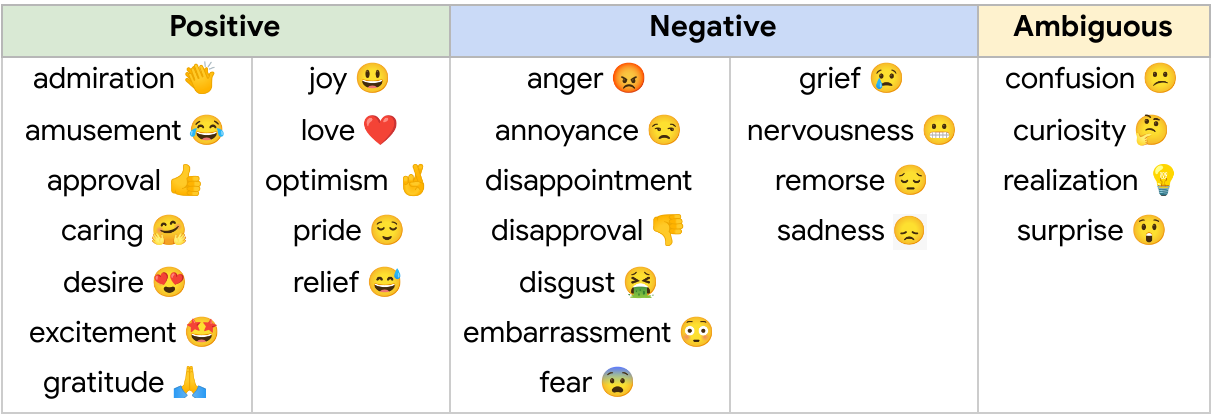

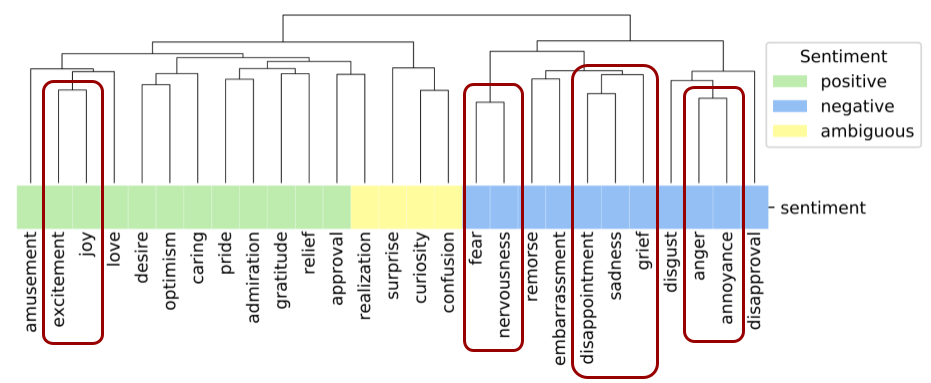

In [174]:
dataset = load_from_disk("./datasets/cleaned_hf/merged_hf")

In [175]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 83016
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 10426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 12721
    })
})

In [176]:
dataset['train'][0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1]}

In [ ]:
# labels
dataset['train'].features['labels'].feature.names

Value(dtype='int64', id=None)

# Display frequency of each emotion

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [181]:
# combine train/validation/test
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
display(len(combined_df))
combined_df.head()

106163

,text,labels
0,My favourite food is anything I didn't have to...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"Now if he does off himself, everyone will thin...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,WHY THE FUCK IS BAYLESS ISOING,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,To make her feel threatened,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Dirty Southern Wankers,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [182]:
train_df.shape

(83016, 2)

In [183]:
val_df.shape

(10426, 2)

In [184]:
test_df.shape

(12721, 2)

In [185]:
len(train_df) + len(val_df) + len(test_df)

106163

In [188]:
freq = np.sum(combined_df['labels'], axis=0)
freq

array([ 5122,  2895,  8739,  3093,  3687,  1375,  1673,  2723,   801,
        1583,  2581,  5033,   375,  1052,  4985,  3372,    96, 12864,
        9366,   208,  5410,   142,  1382,  1706,   669, 15815,  4802,
       26389], dtype=int64)

In [196]:
freq_dict = {}
for i, emo in enumerate(go_labels):
    freq_dict[emo] = freq[i]

freq_dict


{'admiration': 5122,
 'amusement': 2895,
 'anger': 8739,
 'annoyance': 3093,
 'approval': 3687,
 'caring': 1375,
 'confusion': 1673,
 'curiosity': 2723,
 'desire': 801,
 'disappointment': 1583,
 'disapproval': 2581,
 'disgust': 5033,
 'embarrassment': 375,
 'excitement': 1052,
 'fear': 4985,
 'gratitude': 3372,
 'grief': 96,
 'joy': 12864,
 'love': 9366,
 'nervousness': 208,
 'optimism': 5410,
 'pride': 142,
 'realization': 1382,
 'relief': 1706,
 'remorse': 669,
 'sadness': 15815,
 'surprise': 4802,
 'neutral': 26389}

In [202]:
# order in desc order
desc_freq = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
desc_freq

{'neutral': 26389,
 'sadness': 15815,
 'joy': 12864,
 'love': 9366,
 'anger': 8739,
 'optimism': 5410,
 'admiration': 5122,
 'disgust': 5033,
 'fear': 4985,
 'surprise': 4802,
 'approval': 3687,
 'gratitude': 3372,
 'annoyance': 3093,
 'amusement': 2895,
 'curiosity': 2723,
 'disapproval': 2581,
 'relief': 1706,
 'confusion': 1673,
 'disappointment': 1583,
 'realization': 1382,
 'caring': 1375,
 'excitement': 1052,
 'desire': 801,
 'remorse': 669,
 'embarrassment': 375,
 'nervousness': 208,
 'pride': 142,
 'grief': 96}

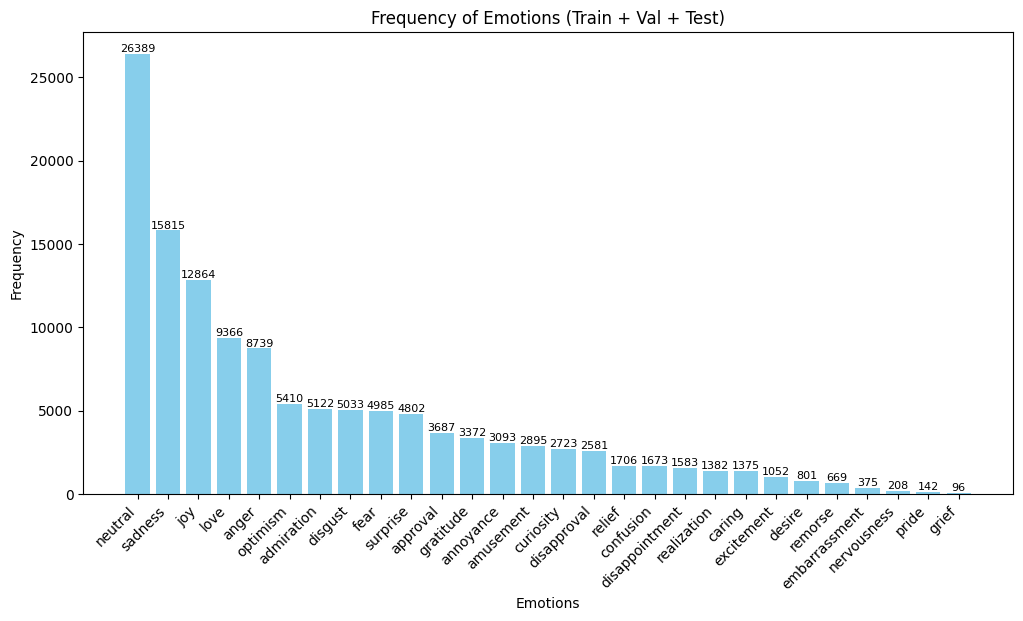

In [205]:
# Plotting the frequency graph
plt.figure(figsize=(12, 6))
bars = plt.bar(desc_freq.keys(), desc_freq.values(), color='skyblue')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Frequency of Emotions (Train + Val + Test)')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()

# Add frequency numbers on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

plt.show()

In [230]:
print(f"{list(desc_freq.keys())[0]} has {26389 / 96} times more samples than {list(desc_freq.keys())[-1]}")

neutral has 274.8854166666667 times more samples than grief


Original GoEmotions dataset freq graph

In [215]:
goEmotions = load_dataset("google-research-datasets/go_emotions")
goEmotions

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [216]:
# combine train/validation/test
train_orig = goEmotions['train'].to_pandas()
val_orig = goEmotions['validation'].to_pandas()
test_orig = goEmotions['test'].to_pandas()

combined_orig = pd.concat([train_orig, val_orig, test_orig], ignore_index=True)
display(len(combined_orig))
combined_orig.head()

54263

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [228]:
def show_freq_graph(emotions_list):
    # flatten labels
    all_labels = [label for labels in emotions_list for label in labels]

    # counter for each label
    label_counts = Counter(all_labels)
    
    # order in desc order
    sorted_freq = dict(label_counts.most_common())


    # Plot the frequencies
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sorted_freq.keys(), sorted_freq.values(), color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Number of examples')
    plt.title('ORIGINAL Label Frequency in GoEmotions Dataset (Train + Valid + Test)')
    plt.xticks(range(len(sorted_freq)), sorted_freq.keys(), rotation=90)  # Rotate labels for readability

    # Add frequency numbers on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=8)

    plt.show()

In [226]:
# change from string labels to ids
labels_str = combined_orig["labels"].apply(lambda label_list: [go_id2label[label] for label in label_list])
labels_str

0           [neutral]
1           [neutral]
2             [anger]
3              [fear]
4         [annoyance]
             ...     
54258     [gratitude]
54259      [approval]
54260       [neutral]
54261    [admiration]
54262       [neutral]
Name: labels, Length: 54263, dtype: object

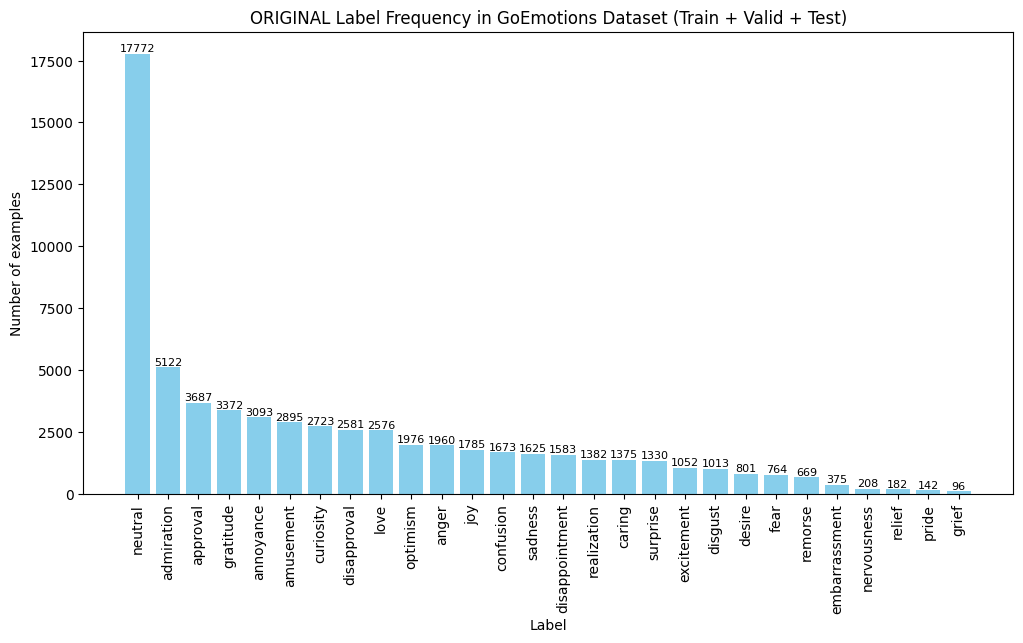

In [229]:
show_freq_graph(labels_str)

Although more data has been added, there's still significant class imbalance due to:
- Other datasets adding onto the majority label ('neutral')
- No/few examples for many minority labels like 'grief' or 'pride'

2 ways to deal with class imbalance:
1. Data Augmentation with TextAttack
2. Class weighting

Notes:
- When using data augmentation, make sure not to over do it as it can lead to overfit.
- When using TextAttack, make sure the augmented examples are of good quality or they can lead to noise or/and can hurt model performance.
- Class weighting: Assign higher importance to minority labels during training. Very useful for (very) imbalanced dataset like this.

# Data Augmentation: TextAttack